In [2]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as la
import tensorflow as tf

2024-04-30 15:54:12.738580: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 15:54:12.910189: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 15:54:13.671486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 15:54:16.176437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Generate datasets

In [3]:
x_train = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
                    4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8])
y_train = np.array([0.169, 0.164, 0.210, 0.215, 0.183, 0.181, 0.188, 0.229,
                    0.268, 0.202, 0.193, 0.262, 0.215, 0.285, 0.313, 0.222, 0.225,
                    0.326, 0.283, 0.374, 0.406, 0.304, 0.284, 0.463, 0.456, 0.598, 0.618,
                    0.475, 0.425, 0.554, 0.810, 1.011, 0.999, 0.751, 0.742, 1.273, 1.300,
                    1.612, 1.588, 1.225, 1.208])

## Defining Functions

We fit a nonlinear model $y = f(x;\beta) + \epsilon$ to a given dataset below, where $f(x;\beta) = \beta_0\cdot\exp(x/\beta_1)$.

In [4]:
def model(x, truth_beta):
    return truth_beta[0]*np.exp(x/truth_beta[1])


def Fval(x, y, beta):
    return model(x, beta) - y


def Jac(x, beta):
    return np.array([np.exp(x/beta[1]), -(beta[0]/beta[1]**2)*np.exp(x/beta[1])*x])

## Default Gauss-Newton Method

Iteration:  0 -- Error: 4.3734e+04
Iteration:  1 -- Error: 1.3142e+03
Iteration:  2 -- Error: 2.6061e+02
Iteration:  3 -- Error: 5.1467e+01
Iteration:  4 -- Error: 9.8034e+00
Iteration:  5 -- Error: 9.5526e-01
Iteration:  6 -- Error: 1.1868e-02
Iteration:  7 -- Error: 1.4007e-06
>>> Convergence achieved!

Parameters: [0.16372089 3.76453933] 
Error:  1.400680826889285e-06 
Number of Iterations:  7


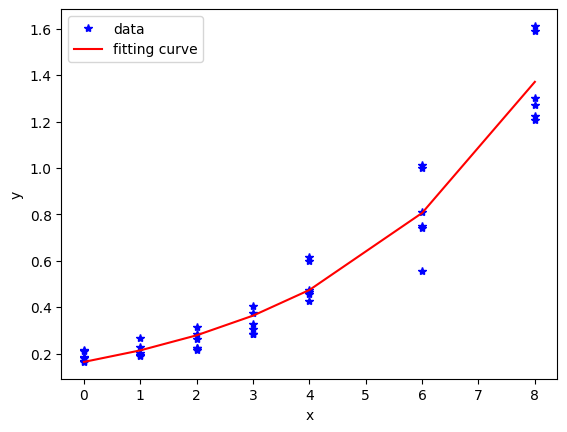

In [5]:
# Default Gauss-Newton Method
def GN(Fx, Jac, x, y, beta0, maxiter = 100, tol = 1e-3):
    bet = beta0
    err  = 0
    for t in range(0, maxiter):
        Ft  = Fx(x, y, bet)
        Jt  = Jac(x, bet)
        St  = la.pinv(Jt.dot(Jt.T))
        yt  = Jt.dot(Ft).T
        dt  = np.ravel(St.dot(yt))
        bet = bet - dt
        err = la.norm(yt)
        print("Iteration: {0:2d}".format(t), "-- Error: {0:5.4e}".format(err))
        if err <= tol:
            print(">>> Convergence achieved!")
            break
    return bet, err, t

# We run it.
beta0 = [1, 2]
beta_best, err, n_it = GN(Fval, Jac, x_train, y_train, beta0, maxiter=1000)
print("\nParameters:", beta_best, "\nError: ", err, "\nNumber of Iterations: ", n_it)

# Plotting
plt.plot(x_train, y_train, 'b*', label='data')
plt.plot(x_train, model(x_train, beta_best), "-r", label="fitting curve")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## AutoDiff Gauss-Newton Method

2024-04-30 15:54:21.466700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-30 15:54:21.467649: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Iteration:  0 -- Error: 4.3734e+04
Iteration:  1 -- Error: 1.3142e+03
Iteration:  2 -- Error: 2.6061e+02
Iteration:  3 -- Error: 5.1467e+01
Iteration:  4 -- Error: 9.8034e+00
Iteration:  5 -- Error: 9.5526e-01
Iteration:  6 -- Error: 1.1868e-02
Iteration:  7 -- Error: 1.4007e-06
>>> Convergence achieved!

Parameters: [0.16372089 3.76453933] 
Error:  1.4006808140952525e-06 
Number of Iterations:  7


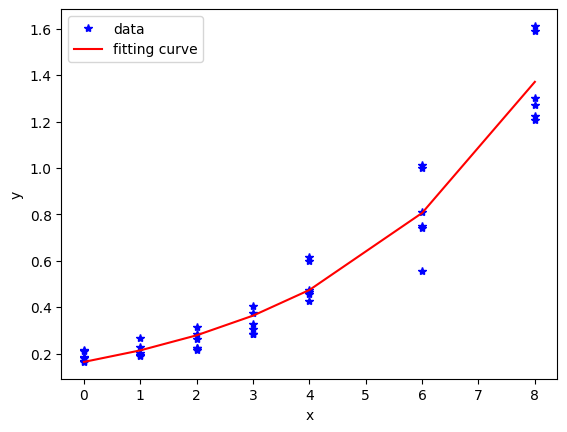

In [6]:
def tf_model(x, truth_beta):
    return tf.multiply(truth_beta[0], tf.exp(tf.divide(x, truth_beta[1])))

# Default Gauss-Newton Method
def GN_Auto_Diff(Fx, tf_Fx, x, y, beta0, maxiter=100, tol=1e-3):
    bet = beta0
    err = 0
    for t in range(0, maxiter):
        Ft = Fx(x, y, bet)

        # Compute value of Jacobian matrix using Auto Diff
        tf_x = tf.constant(x, dtype=tf.float64)
        tf_bet = tf.Variable(bet, dtype=tf.float64)
        with tf.GradientTape() as tape:
            J = tf_Fx(tf_x, tf_bet)
        Jt = tape.jacobian(J, tf_bet).numpy().T
        
        St = la.pinv(Jt.dot(Jt.T))
        yt = Jt.dot(Ft).T
        dt = np.ravel(St.dot(yt))
        bet = bet - dt
        err = la.norm(yt)
        print("Iteration: {0:2d}".format(t), "-- Error: {0:5.4e}".format(err))
        if err <= tol:
            print(">>> Convergence achieved!")
            break
    return bet, err, t


# Running
beta0 = [1, 2]
beta_best, err, n_it = GN_Auto_Diff(Fval, tf_model, x_train, y_train, beta0, maxiter=1000)
print("\nParameters:", beta_best, "\nError: ", err, "\nNumber of Iterations: ", n_it)

# Plotting
plt.plot(x_train, y_train, 'b*', label='data')
plt.plot(x_train, model(x_train, beta_best), "-r", label="fitting curve")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Damped Gauss-Newton Method

Iteration:  0 -- Error: 4.3734e+04
Iteration:  1 -- Error: 3.6263e+04
Iteration:  2 -- Error: 3.0173e+04
Iteration:  3 -- Error: 2.5198e+04
Iteration:  4 -- Error: 2.1125e+04
Iteration:  5 -- Error: 1.7781e+04
Iteration:  6 -- Error: 1.5026e+04
Iteration:  7 -- Error: 1.2747e+04
Iteration:  8 -- Error: 1.0855e+04
Iteration:  9 -- Error: 9.2753e+03
Iteration: 10 -- Error: 7.9510e+03
Iteration: 11 -- Error: 6.8347e+03
Iteration: 12 -- Error: 5.8892e+03
Iteration: 13 -- Error: 5.0843e+03
Iteration: 14 -- Error: 4.3962e+03
Iteration: 15 -- Error: 3.8054e+03
Iteration: 16 -- Error: 3.2964e+03
Iteration: 17 -- Error: 2.8566e+03
Iteration: 18 -- Error: 2.4756e+03
Iteration: 19 -- Error: 2.1450e+03
Iteration: 20 -- Error: 1.8578e+03
Iteration: 21 -- Error: 1.6082e+03
Iteration: 22 -- Error: 1.3911e+03
Iteration: 23 -- Error: 1.2025e+03
Iteration: 24 -- Error: 1.0385e+03
Iteration: 25 -- Error: 8.9626e+02
Iteration: 26 -- Error: 7.7292e+02
Iteration: 27 -- Error: 6.6613e+02
Iteration: 28 -- Err

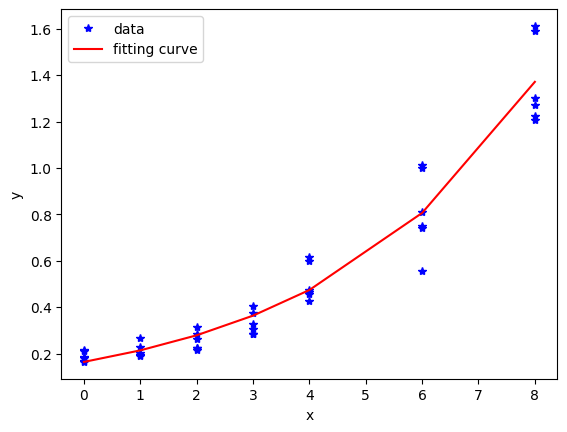

In [7]:
# Damped Gauss-Newton Method
def GN_damped(Fx, Jac, x, y, beta0, stepsize=1, maxiter=100, tol=1e-3):
    bet = beta0
    err = 0
    t = 0
    while t < maxiter:
        Ft = Fx(x, y, bet)
        Jt = Jac(x, bet)
        St = la.pinv(Jt.dot(Jt.T))
        yt = Jt.dot(Ft).T
        dt = np.ravel(St.dot(yt))
        err = la.norm(yt)

        # Add step size
        bet = bet - stepsize * dt
        
        print("Iteration: {0:2d}".format(t), "-- Error: {0:5.4e}".format(err))
        if err <= tol:
            print(">>> Convergence achieved!")
            break
        t += 1
    return bet, err, t


# We run it.
beta0 = [1, 2]
beta_best, err, n_it = GN_damped(
    Fval, Jac, x_train, y_train, beta0=beta0, stepsize=0.1, maxiter=1000)
print("\nParameters:", beta_best, "\nError: ",
      err, "\nNumber of Iterations: ", n_it)

# Plotting
plt.plot(x_train, y_train, 'b*', label='data')
plt.plot(x_train, model(x_train, beta_best), "-r", label="fitting curve")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Line Search

### Naive Approach

Iteration:  0 -- Error: 4.9970e+02
Line Search
Line Search
Line Search
Line Search
Line Search
Line Search
Iteration:  1 -- Error: 2.5638e+01
Line Search
Line Search
Line Search
Line Search
Iteration:  2 -- Error: 3.7029e+01
Line Search
Iteration:  3 -- Error: 6.4720e+01
Iteration:  4 -- Error: 2.0383e+01
Iteration:  5 -- Error: 3.4447e+00
Iteration:  6 -- Error: 7.4929e-02
Iteration:  7 -- Error: 6.8102e-05
>>> Convergence achieved!

Parameters: [0.16372089 3.76453933] 
Error:  6.810234804050422e-05 
Number of Iterations:  7


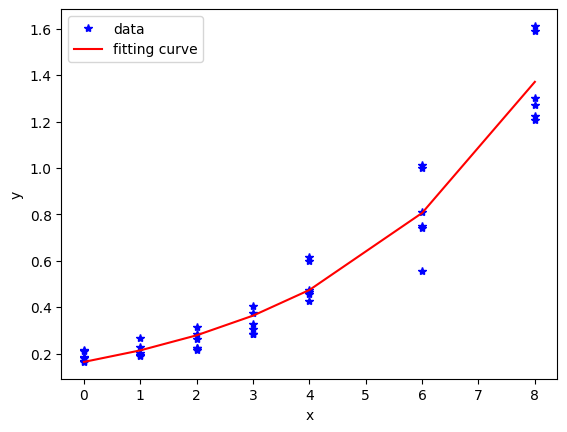

In [8]:
# Damped Gauss-Newton Method
def GN_naive_linesearch(Fx, Jac, x, y, beta0, stepsize=1, maxiter=100, tol=1e-3):
    beta = beta0
    err = 0
    t = 0
    while t < maxiter:
        Ft = Fx(x, y, beta)
        Jt = Jac(x, beta)
        St = la.pinv(Jt.dot(Jt.T))
        yt = Jt.dot(Ft).T
        dt = np.ravel(St.dot(yt))
        err = la.norm(yt)

        # Naive Line Search
        current_stepsize = stepsize
        while True:
            next_bet = beta - current_stepsize * dt
            next_Ft = Fx(x, y, next_bet)
            if la.norm(next_Ft) <= la.norm(Ft):
                break
            print("Line Search")
            current_stepsize /= 2

        beta = next_bet
        print("Iteration: {0:2d}".format(t), "-- Error: {0:5.4e}".format(err))
        if err <= tol:
            print(">>> Convergence achieved!")
            break
        t += 1
    return beta, err, t


# We run it.
beta0 = [10, 30]
beta_best, err, n_it = GN_naive_linesearch(
    Fval, Jac, x_train, y_train, beta0=beta0, maxiter=1000)
print("\nParameters:", beta_best, "\nError: ",
      err, "\nNumber of Iterations: ", n_it)

# Plotting
plt.plot(x_train, y_train, 'b*', label='data')
plt.plot(x_train, model(x_train, beta_best), "-r", label="fitting curve")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Armijo Condition

### Wolfe Condition